In [1]:
!pip install pandas --upgrade

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from catboost import Pool, CatBoostClassifier
import missingno as msno
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-olympiad-into-the-space/sample_submission.csv
/kaggle/input/ml-olympiad-into-the-space/train.csv
/kaggle/input/ml-olympiad-into-the-space/test.csv


In [3]:
train = pd.read_csv("/kaggle/input/ml-olympiad-into-the-space/train.csv", index_col = "PassengerId")
test = pd.read_csv("/kaggle/input/ml-olympiad-into-the-space/test.csv", index_col = "PassengerId")
sample_submission = pd.read_csv("/kaggle/input/ml-olympiad-into-the-space/sample_submission.csv")

In [4]:
train.head(5)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
test.head(5)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
PassengerId,,,,,,,,,,,,
0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [6]:
sample_submission.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


In [7]:
test.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000


In [8]:
test.isnull().sum()

HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

<AxesSubplot:>

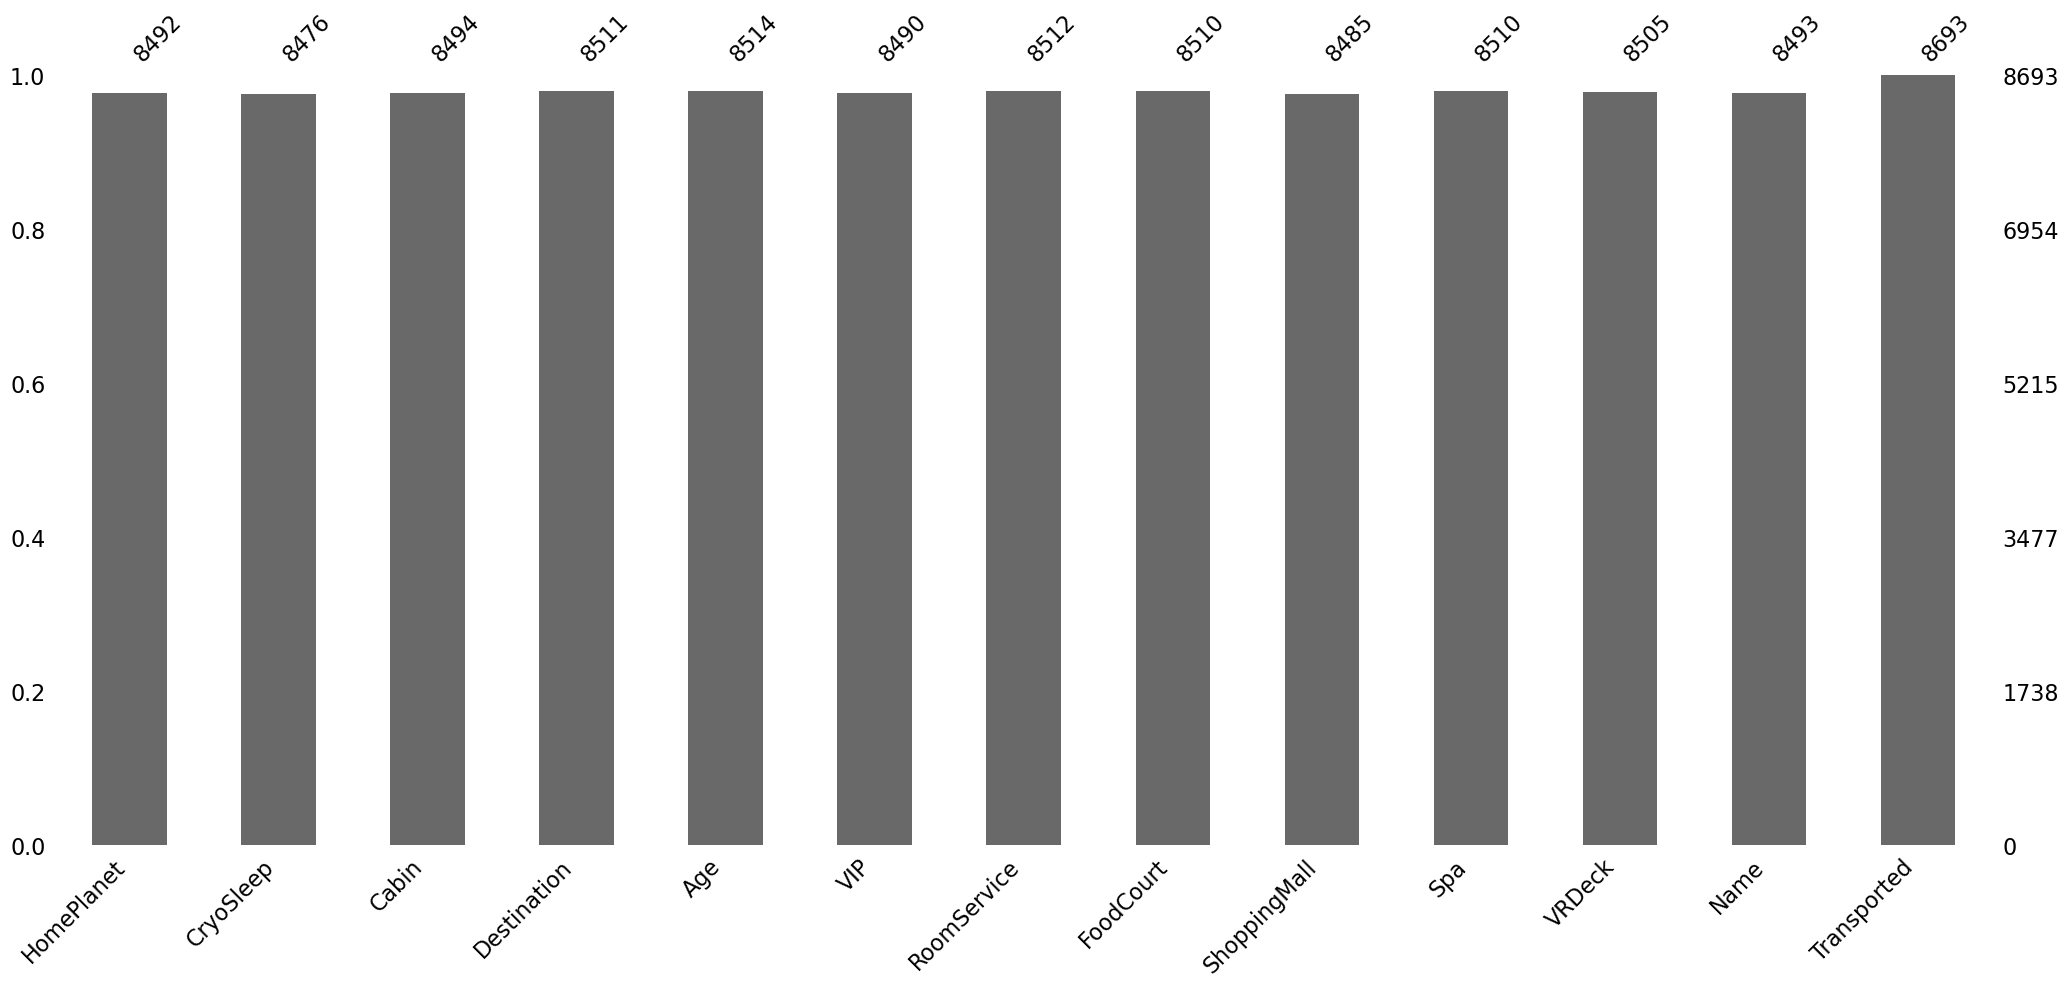

In [9]:
msno.bar(train)

### Let's separate the cabin columns into three new features: deck, num and side.

In [10]:
train[["deck", "num", "side"]] = train["Cabin"].str.split("/", expand = True)
test[["deck", "num", "side"]] = test["Cabin"].str.split("/", expand = True)

In [11]:
object_cols = [col for col in train.columns if train[col].dtype == 'object' or train[col].dtype == 'category']
numeric_cols = [col for col in train.columns if train[col].dtype == 'float64']

In [12]:
print(object_cols)

['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name', 'deck', 'num', 'side']


In [13]:
print(numeric_cols)

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


In [14]:
col_to_sum = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

In [15]:
train["SumSpends"] = train[col_to_sum].sum(axis = 1)
test["SumSpends"] = test[col_to_sum].sum(axis = 1)

In [16]:
null_cols = train.isnull().sum().sort_values(ascending=False)
null_cols = list(null_cols[null_cols>1].index)
null_cols

['CryoSleep',
 'ShoppingMall',
 'VIP',
 'HomePlanet',
 'Name',
 'Cabin',
 'deck',
 'num',
 'side',
 'VRDeck',
 'FoodCourt',
 'Spa',
 'Destination',
 'RoomService',
 'Age']

In [17]:
train[object_cols] = train[object_cols].astype("category")
test[object_cols] = test[object_cols].astype("category")

In [18]:
print(train.shape)

(8693, 17)


In [19]:
print(test.shape)

(4277, 16)


## Encoding the Categorical Variables

In [20]:
from sklearn.preprocessing import OrdinalEncoder

oc = OrdinalEncoder()

df_for_encode = pd.concat([train, test])

df_for_encode[object_cols] = df_for_encode[object_cols].astype('category')

df_for_encode[object_cols] = oc.fit_transform(df_for_encode[object_cols])

del train, test

train = df_for_encode.iloc[:8693, :]
test = df_for_encode.iloc[8693: , :]

del df_for_encode

test.drop('Transported', inplace=True, axis=1)

In [21]:
print(train.shape)

(8693, 17)


In [22]:
print(test.shape)

(4277, 16)


In [23]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer([("imp", SimpleImputer(strategy="mean"), null_cols)])

train[null_cols] = ct.fit_transform(train[null_cols])
test[null_cols] = ct.fit_transform(test[null_cols])

In [24]:
X = train.copy()
y = X.pop("Transported")

### A free of modularity in feature engineering

In [25]:
!pip install headjackai-sdk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.6/525.6 kB 29.9 MB/s eta 0:00:00
  Attempting uninstall: charset-normalizer
    Found existing installation: charset-normalizer 2.1.1
    Uninstalling charset-normalizer-2.1.1:
      Successfully uninstalled charset-normalizer-2.1.1
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
  Attempting uninstall: requests
    Found existing installation: requests 2.28.2
    Uninstalling requests-2.28.2:
      Successfully uninstalled requests-2.28.2
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled p

In [26]:
from headjackai.headjackai_hub import headjackai_hub

#host setting
hj_hub = headjackai_hub("http://www.headjackai.com:9000")
hj_hub.login(username = "jimliu_kaggle", pwd = "12345678")

'Login Successful!'

In [27]:
hj_hub.knowledgepool_check(public_pool = True)

['kaggle_brijbhushannanda1979_bigmart_sales_data',
 'kaggle_blastchar_telco_customer_churn',
 'kaggle_lava18_google_play_store_apps',
 'kaggle_madislemsalu_facebook_ad_campaign',
 'kaggle_datasets_mhdzahier_travel_insurance',
 'kaggle_zhijinzhai_loandata',
 'kaggle_janiobachmann_bank_marketing_dataset',
 'kaggle_santoshd3_bank_customers',
 'kaggle_mahirahmzh_starbucks_customer_retention_malaysia_survey',
 'kaggle_ihormuliar_starbucks_customer_data',
 'kaggle_luiscorter_netflix_original_films_imdb_scores',
 'kaggle_shivamb_hm_stores_dataset',
 'kaggle_vivovinco_nba_player_stats',
 'kaggle_the_winton_stock_market_challenge_one',
 'kaggle_muthuj7_weather_dataset',
 'kaggle_rinichristy_2022_fuel_consumption_ratings',
 'kaggle_gsutters_economic_freedom',
 'kaggle_chrischien17_taiwan_taipei_city_real_estate_transaction_records',
 'kaggle_nenamalikah_nft_collections_by_sales_volume',
 'symphox_vouch_offline_interest',
 'symphox_offline_time',
 'symphox_online_time',
 'symphox_online_interest'

In [28]:
#in this case, we select drug_type as our features engineering function and the features from misaelcribeiro picked. 
source = 'drug_type'


best_features = [
 'Spaceship-Titanic-CryoSleep',
 'Spaceship-Titanic-RoomService',
 'Spaceship-Titanic-Spa',
 'Spaceship-Titanic-VRDeck',
 'Spaceship-Titanic-deck',
 'Spaceship-Titanic-side',
 'Spaceship-Titanic-SumSpends',
 'drug_type-Sex']


#run features engineering on hj 
hj_X = hj_hub.knowledge_transform(data=X, target_domain='Spaceship-Titanic', 
                                  source_domain=source,
                                  label='')

hj_ts_X = hj_hub.knowledge_transform(data=test, target_domain='Spaceship-Titanic', 
                                  source_domain=source,
                                  label='') 

In [29]:
print(X.shape)

(8693, 16)


In [30]:
print(hj_X.shape)

(8693, 22)


In [31]:

model = CatBoostClassifier(verbose=False, eval_metric='Accuracy',random_seed=2222)

model.fit(hj_X[best_features], y)
prediction = model.predict(hj_ts_X[best_features])

In [32]:
#Prediction
final = pd.DataFrame()
final.index = test.index
final['Transported'] = prediction
final['Transported'].replace(0, False, inplace=True)
final['Transported'].replace(1, True, inplace=True)

In [33]:
#final.to_csv('submission.csv')